In [673]:
# referrence:  https://keras.io/examples/timeseries/timeseries_weather_forecasting/
import sys
sys.path.append('../')
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import missingno as msno
from sklearn.preprocessing import StandardScaler
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

In [674]:
DATA_DIR = '../../data/data_daily_with_aqi.csv'
raw_df = pd.read_csv(DATA_DIR)
# test = raw_df[raw_df.date>'2022-01-01']
# train = raw_df[raw_df.date<'2022-01-01']
# raw_df = train

In [675]:
raw_df.type.unique()

array(['O3_24h', 'NO2_24h', 'SO2_24h', 'PM2.5_24h', 'AQI'], dtype=object)

In [676]:
df = raw_df[raw_df['type']=='AQI'].drop('type',axis=1)


In [677]:
df = df.drop(['date','hour'],axis=1)

In [678]:
for i in range(1,6):
    df['lag'+str(i)] = df['北京'].shift(i)

In [679]:
df = df.fillna(method='ffill')

In [680]:
df = df.dropna(how='any')

In [681]:
df = df.loc[:,['北京','lag1','lag2','lag3','lag4','lag5']]

In [682]:
step = 1
past = 200
future = 15
learning_rate = 1e-4
batch_size = 256
epochs = 500
sequence_length = 1

# df = df.apply(np.log).diff(1)


df['label'] = df['北京'].shift(-future)
df =  df.fillna(method='ffill').dropna(how='any',axis=0)
df = df.reset_index(drop=True)

In [683]:

split_fraction = 0.7
train_split = int(split_fraction * int(df.shape[0]))

In [684]:
features = df.reset_index(drop=True)
# features = normalize(features.values, train_split)
# features = pd.DataFrame(features)
# features.head()
train_data = features.iloc[: train_split,:]
val_data = features.iloc[train_split-sequence_length:,:]

In [685]:
x_train = train_data.iloc[:,:-1].values
y_train = train_data.iloc[:,-1].values
x_val = val_data.iloc[:,:-1].values
y_val = val_data.iloc[:,-1].values
x_scaler = StandardScaler()
y_scaler = StandardScaler()
x_train = x_scaler.fit_transform(x_train)
x_val = x_scaler.transform(x_val)
y_train = y_scaler.fit_transform(y_train.reshape(-1,1))
y_val = y_scaler.transform(y_val.reshape(-1,1))


In [686]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [687]:
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.shape)
print("Target shape:", targets.shape)

Input shape: (256, 1, 6)
Target shape: (256, 1)


In [688]:
# inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
# outputs = keras.layers.Dense(32)(inputs)
# outputs2 = keras.layers.Dense(16)(outputs)
# outputs3 = keras.layers.Dense(1)(outputs2)
# model = keras.Model(inputs=inputs, outputs=outputs3)
model = keras.models.Sequential([
    keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2])),
    keras.layers.Dense(32),
    keras.layers.Dense(16),
    keras.layers.Dense(1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 1, 32)             224       
                                                                 
 dense_83 (Dense)            (None, 1, 16)             528       
                                                                 
 dense_84 (Dense)            (None, 1, 1)              17        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [689]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=15, verbose=1, mode="auto", baseline=None, restore_best_weights=True)
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, 
               modelckpt_callback,
               ],
)

Epoch 1/500
1/9 [==>...........................] - ETA: 2s - loss: 3.7340

2022-05-22 10:19:31.408649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 2.2140
Epoch 1: val_loss improved from inf to 1.40343, saving model to model_checkpoint.h5
9/9 [==============================] - 1s 63ms/step - loss: 2.2140 - val_loss: 1.4034
Epoch 2/500


2022-05-22 10:19:31.937655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9/9 [==============================] - ETA: 0s - loss: 2.1003
Epoch 2: val_loss improved from 1.40343 to 1.32080, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 25ms/step - loss: 2.1003 - val_loss: 1.3208
Epoch 3/500
9/9 [==============================] - ETA: 0s - loss: 1.9982
Epoch 3: val_loss improved from 1.32080 to 1.24282, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 24ms/step - loss: 1.9982 - val_loss: 1.2428
Epoch 4/500
9/9 [==============================] - ETA: 0s - loss: 1.9038
Epoch 4: val_loss improved from 1.24282 to 1.17002, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 24ms/step - loss: 1.9038 - val_loss: 1.1700
Epoch 5/500
9/9 [==============================] - ETA: 0s - loss: 1.8167
Epoch 5: val_loss improved from 1.17002 to 1.10254, saving model to model_checkpoint.h5
9/9 [==============================] - 0s 23ms/step - loss: 1.8167 - val_loss: 1.1025
Epoch 6/500
5/9 [===

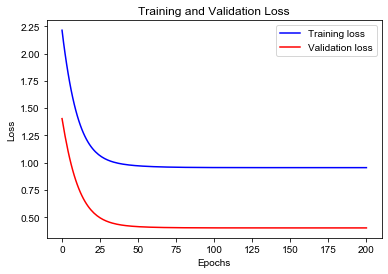

In [690]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [691]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



4/4 [==============================] - 0s 19ms/step


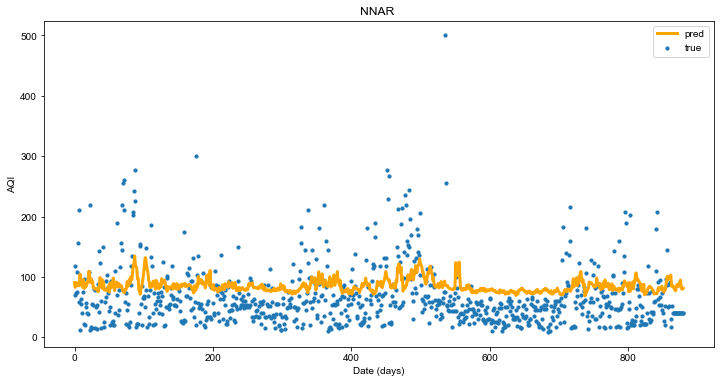

In [696]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_val)
y_pred = y_scaler.inverse_transform(pred.flatten().reshape(-1,1))
y_true = y_scaler.inverse_transform(y_val.flatten()[-len(y_pred):].reshape(-1,1))
plt.figure(figsize=(12, 6))
plt.plot(y_pred,label = 'pred',color = 'orange',linewidth=3)
plt.scatter(list(range(len(y_true))),y_true,label='true',s=10)
plt.legend()
plt.xlabel('Date (days)')
plt.ylabel('AQI')
plt.title('NNAR ')
plt.savefig('../time_series/pic/day/nnar_daily.png')

In [693]:
from metrics import calc_metric
calc_metric(y_scaler.inverse_transform( y_true.reshape(-1,1)),y_scaler.inverse_transform( y_pred.reshape(-1,1)),'nnar').to_csv('../result/nnar_daily.csv')


In [694]:
model.save('./models/lstm_128_dense_1.h5')

9/9 [==============================] - 0s 12ms/step


Text(0.5, 1.0, 'r2_score:0.0464')

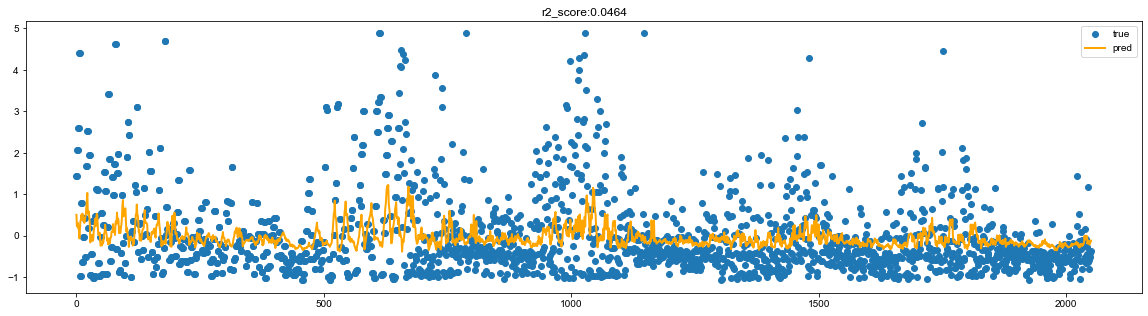

In [695]:
from sklearn.metrics import r2_score
pred = model.predict(dataset_train)
y_pred = pred.flatten()
y_true = y_train.flatten()[-len(y_pred):]
plt.figure(figsize=(20, 5))

plt.scatter(list(range(len(y_true))),y_true,label='true')
plt.plot(y_pred,label = 'pred',color='orange',linewidth=2)
plt.legend()
plt.title('r2_score:{:.4f}'.format(r2_score(y_true,y_pred)))
